# I. Autoencoder (Inception Nucleus) with dropout

1. Using dropout only in the encoder helps the model generalize better by regularizing the feature extraction process.
2. Not using dropout in the decoder allows the decoder to focus on accurately reconstructing the input, which is critical for tasks like autoencoding.
3. This combination is a common practice in autoencoders and other neural networks because it balances regularization with accurate output generation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, Conv1DTranspose, Dropout, Dense, Flatten

gpus = tf.config.list_physical_devices('GPU')
device = '/device:GPU:0' if gpus else '/device:CPU:0'
print(f"Using device: {device}")

2024-11-13 20:42:35.584267: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 20:42:36.053294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 20:42:36.053330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 20:42:36.053338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 20:42:36.301939: I tensorflow/core/platform/cpu_feature_g

Using device: /device:GPU:0


2024-11-13 20:42:40.447027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 20:42:40.872649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 20:42:40.877080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def InceptionNucleus(input_layer, filters, one_d_dropout_rate=0):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(one_d_dropout_rate)(x)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def InceptionNucleusTranspose(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1DTranspose(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_autoencoder(one_d_dropout_rate=0, two_d_dropout_rate=0):
    # Encoder
    inputs = Input(shape=(178, 1))

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12], one_d_dropout_rate=one_d_dropout_rate)

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x)  # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(two_d_dropout_rate)(x)
    encoded = MaxPooling2D((2, 2))(x)  # Compressed representation (encoder output)

    # Decoder: reverse the encoder
    x = UpSampling2D((2, 2))(encoded)  # Reverse the max-pooling
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Reshape back to 1D format for InceptionNucleusTranspose
    x = Reshape((178, 96 * 64))(x)  # Flatten the feature maps
    x = Conv1D(96, kernel_size=1, activation='relu')(x)  # Reduce feature maps from 96 * 64 to 96

    # InceptionNucleusTranspose: reverse the multi-scale convolutions
    x = InceptionNucleusTranspose(x, filters=[4, 8, 12])

    # Final reconstruction layer to original input dimensions
    outputs = Conv1D(1, kernel_size=1, padding='same', activation='sigmoid')(x)

    # Autoencoder Model
    autoencoder = Model(inputs=inputs, outputs=outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Create a separate encoder model
    encoder = Model(inputs=inputs, outputs=encoded)

    return autoencoder, encoder

autoencoder, encoder = create_eeg_autoencoder()
print ("Autoencoder:")
autoencoder.summary()
print ("Encoder:")
encoder.summary()

2024-11-13 20:42:40.920311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 20:42:40.923277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 20:42:40.926016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Autoencoder:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 178, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 178, 32)              160       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 178, 32)              288       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 178, 32)              416       ['input_1[0][0]']             
                                                                                 

In [29]:
# Load data
def load_train_hard_test_split():
    train_data = pd.read_csv('hard_test_cases/train.csv', index_col=0)
    test_data = pd.read_csv('hard_test_cases/test.csv', index_col=0)

    X_train = train_data.iloc[:, :-1].values  # X1-X178
    X_test = test_data.iloc[:, :-1].values    # X1-X178

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data for the model
    X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
    X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

    # y data
    y_train = train_data['y']
    y_test = test_data['y']
    y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
    
    return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler


def load_train_test_split():
    df = pd.read_csv('data/cleaned_data.csv')
    X = df.drop(columns=['label']).values  # Features
    y = df['label'].values  # Target variable

    # Check if the number of features is 178 as expected
    if X.shape[1] != 178:
        raise ValueError(f"Expected 178 features, but got {X.shape[1]}")

    # Perform an 80-20 split for train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train).reshape(-1, 178, 1)
    X_test_scaled = scaler.transform(X_test).reshape(-1, 178, 1)

    # Convert y data to arrays if necessary
    y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test

    return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler

    

In [4]:
# Define the main function for training the autoencoder
def train(device, X_train, X_test, epochs=3, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0):
    
    with tf.device(device): 
        # Define and compile the autoencoder
        autoencoder, encoder = create_eeg_autoencoder(one_d_dropout_rate=one_d_dropout_rate, two_d_dropout_rate=two_d_dropout_rate)
        autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the autoencoder
        history = autoencoder.fit(
            X_train, X_train,  # Training the autoencoder to reconstruct the input
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
    
    with tf.device(device): 
        # Evaluate on test data
        test_loss = autoencoder.evaluate(X_test, X_test)
        print("Test loss (reconstruction error):", test_loss)

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))  # Create a new figure
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()  # Make sure subplots are nicely spaced
    plt.show()  # Show plot here to avoid overlap with other plots
    
    return autoencoder, encoder


def visualize(X_test, X_test_scaled, autoencoder, scaler):
    # Check if the input is a single sample or the entire dataset
    if len(X_test_scaled.shape) == 2:  # Shape (178, 1), single sample
        original_sample_scaled = X_test_scaled
    else:  # Assume the input is the full dataset (1112, 178, 1), take the first sample
        original_sample_scaled = X_test_scaled[0]  # Shape (178, 1)

    # Reshape it for prediction (add batch dimension)
    original_sample_scaled = np.expand_dims(original_sample_scaled, axis=0)  # Shape (1, 178, 1)

    # Reconstruct test data using the autoencoder
    reconstructed_scaled = autoencoder.predict(original_sample_scaled, verbose=0).reshape(178, 1)

    # Reshape reconstructed_scaled to match the shape that the scaler expects (1, 178)
    reconstructed_scaled = reconstructed_scaled.reshape(1, 178)
    reconstructed_unscaled = scaler.inverse_transform(reconstructed_scaled)

    # Flatten original_sample_scaled for plotting (remove batch and feature dims)
    X_test_flat = X_test.flatten()

    # Flatten reconstructed_unscaled for plotting
    reconstructed_unscaled_flat = reconstructed_unscaled.flatten()

    # Plot original and reconstructed test samples
    plt.figure(figsize=(12, 6))  # Create a new figure for this plot
    plt.plot(X_test_flat, label='Original')  # Flatten for plotting
    plt.plot(reconstructed_unscaled_flat, label='Reconstructed', color='orange')  # Flatten for plotting
    plt.title('Original vs Reconstructed Test Sample')
    plt.legend()

    plt.tight_layout()  # Ensure subplots are well spaced
    plt.show()


In [ ]:
def train_and_test_autoencoder(epochs=3, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0):
    # 1. Load the data
    train_data = pd.read_csv('hard_test_cases/train.csv', index_col=0)
    test_data = pd.read_csv('hard_test_cases/test.csv', index_col=0)
    
    X_train = train_data.iloc[:, :-1].values  # X1-X178
    X_test = test_data.iloc[:, :-1].values    # X1-X178
    
    # 2. Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape the data
    X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
    X_test_scaled = X_test_scaled.reshape(-1, 178, 1)
    
    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    device = '/device:GPU:0' if gpus else '/device:CPU:0'
    print(f"Using device: {device}")
    
    with tf.device(device): 
        # 3. Define and compile the autoencoder
        autoencoder, encoder = create_eeg_autoencoder(one_d_dropout_rate=one_d_dropout_rate, two_d_dropout_rate=two_d_dropout_rate)
        autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # 4. Train the autoencoder
        history = autoencoder.fit(
            X_train_scaled, X_train_scaled,  # Training the autoencoder to reconstruct the input
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
    
    with tf.device(device): 
        # 5. Evaluate on test data
        test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled)
        print("Test loss (reconstruction error):", test_loss)
        
        # 6. Use the autoencoder to make predictions (reconstruct the test data)
        X_test_reconstructed = autoencoder.predict(X_test_scaled)
    
    # Bring it back to the original scale
    X_test_reconstructed_unscaled = scaler.inverse_transform(X_test_reconstructed.reshape(-1, 178))
    
    # 7. Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # 8. Plot original and reconstructed test samples
    plt.subplot(1, 2, 2)
    plt.plot(X_test[0], label='Original')
    plt.plot(X_test_reconstructed_unscaled[0], label='Reconstructed')
    plt.title('Original vs Reconstructed Test Sample')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return autoencoder, encoder

## Baseline: No dropout

Using device: /device:GPU:0
Epoch 1/10


2024-11-13 20:42:57.334795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-13 20:43:00.962594: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f97c8029b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-13 20:43:00.962628: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-13 20:43:01.011246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 20:43:01.233050: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 33s 89ms/step - loss: 8.0718e-04 - val_loss: 0.0050
Epoch 2/10
260/260 [==============================] - 20s 79ms/step - loss: 1.6444e-04 - val_loss: 0.0031
Epoch 3/10
260/260 [==============================] - 21s 79ms/step - loss: 1.0836e-04 - val_loss: 2.4818e-04
Epoch 4/10
260/260 [==============================] - 21s 79ms/step - loss: 8.3277e-05 - val_loss: 7.7648e-05
Epoch 5/10
260/260 [==============================] - 21s 79ms/step - loss: 6.6570e-05 - val_loss: 6.4071e-05
Epoch 6/10
260/260 [==============================] - 21s 79ms/step - loss: 5.6005e-05 - val_loss: 4.5224e-05
Epoch 7/10
260/260 [==============================] - 21s 79ms/step - loss: 5.0755e-05 - val_loss: 3.8528e-05
Epoch 8/10
260/260 [==============================] - 21s 79ms/step - loss: 4.5682e-05 - val_loss: 4.5579e-05
Epoch 9/10
260/260 [==============================] - 21s 80ms/step - loss: 3.8351e-05 - val_loss: 2.8538e-05
Epoch 10/10
35/35 [==========

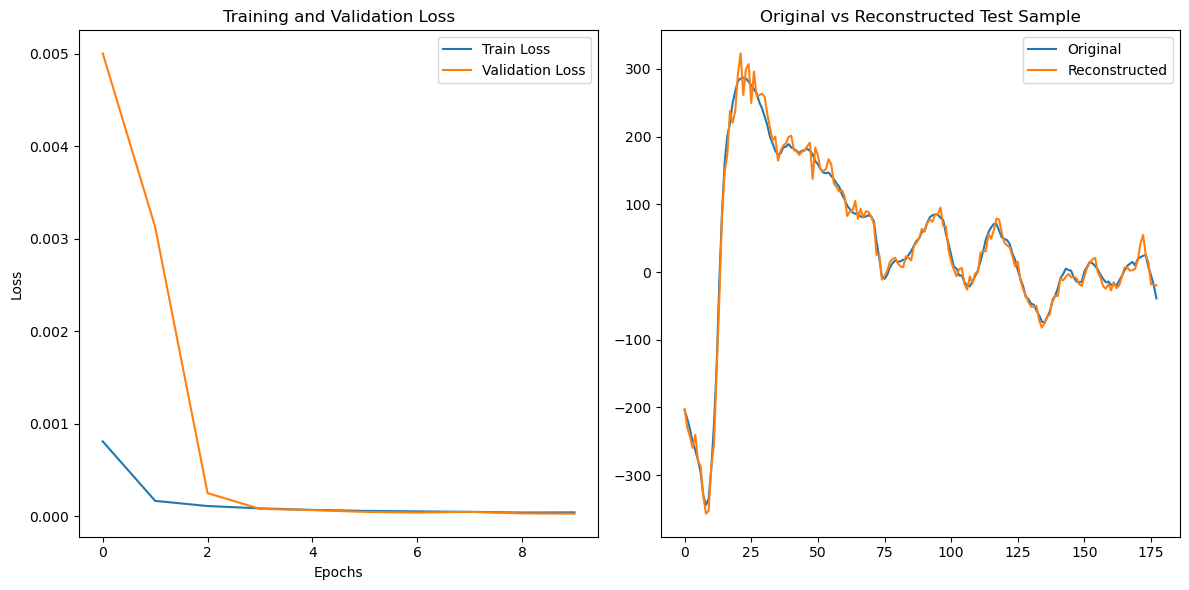

In [6]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0)

## Experiment 1: Dropout after 1d Conv

### Dropout=0.25

Using device: /device:GPU:0
Epoch 1/10


2024-11-12 01:03:20.752922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-12 01:03:25.234434: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f66805fd110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-12 01:03:25.234462: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-12 01:03:25.283152: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-12 01:03:25.494632: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 34s 88ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 2/10
260/260 [==============================] - 20s 78ms/step - loss: 3.5084e-04 - val_loss: 0.0029
Epoch 3/10
260/260 [==============================] - 20s 78ms/step - loss: 2.3379e-04 - val_loss: 3.4399e-04
Epoch 4/10
260/260 [==============================] - 20s 78ms/step - loss: 1.7614e-04 - val_loss: 1.7086e-04
Epoch 5/10
260/260 [==============================] - 20s 78ms/step - loss: 1.4657e-04 - val_loss: 1.4933e-04
Epoch 6/10
260/260 [==============================] - 20s 79ms/step - loss: 1.1692e-04 - val_loss: 1.2757e-04
Epoch 7/10
260/260 [==============================] - 20s 78ms/step - loss: 1.0465e-04 - val_loss: 1.6206e-04
Epoch 8/10
260/260 [==============================] - 20s 79ms/step - loss: 9.6076e-05 - val_loss: 1.3784e-04
Epoch 9/10
260/260 [==============================] - 20s 78ms/step - loss: 8.6193e-05 - val_loss: 1.6567e-04
Epoch 10/10
35/35 [==============

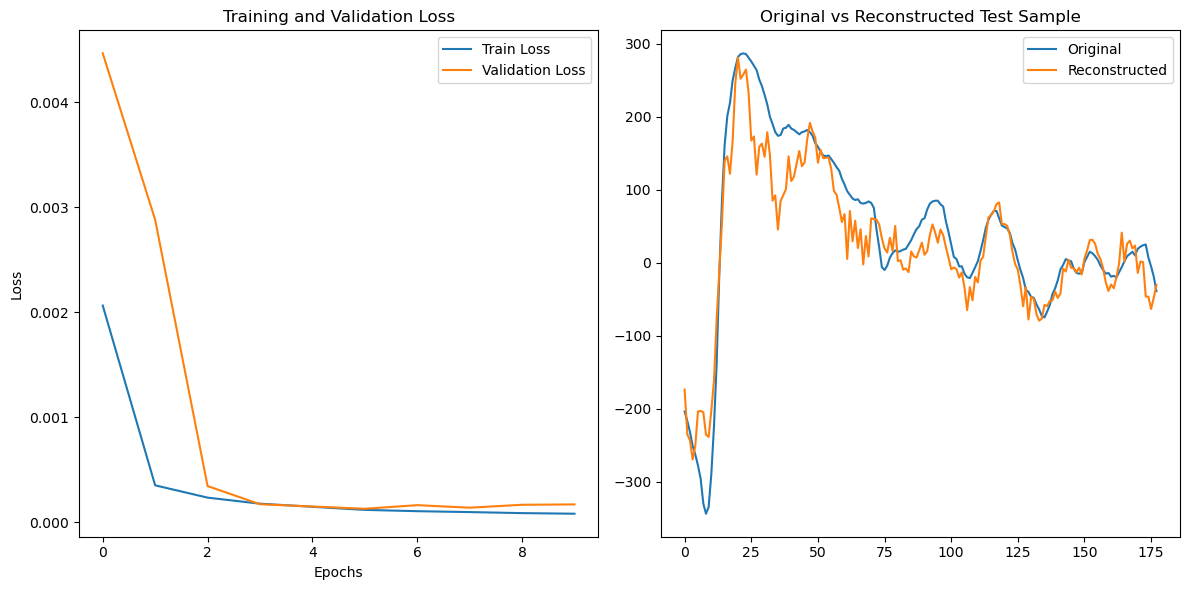

In [6]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0.25, two_d_dropout_rate=0)

### Dropout=0.5

Using device: /device:GPU:0
Epoch 1/10
260/260 [==============================] - 24s 79ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 2/10
260/260 [==============================] - 20s 78ms/step - loss: 4.6930e-04 - val_loss: 0.0026
Epoch 3/10
260/260 [==============================] - 20s 78ms/step - loss: 3.1627e-04 - val_loss: 0.0010
Epoch 4/10
260/260 [==============================] - 20s 78ms/step - loss: 2.5517e-04 - val_loss: 7.0218e-04
Epoch 5/10
260/260 [==============================] - 20s 78ms/step - loss: 2.1773e-04 - val_loss: 7.3747e-04
Epoch 6/10
260/260 [==============================] - 20s 78ms/step - loss: 1.8650e-04 - val_loss: 8.1023e-04
Epoch 7/10
260/260 [==============================] - 20s 78ms/step - loss: 1.6033e-04 - val_loss: 8.2160e-04
Epoch 8/10
260/260 [==============================] - 20s 79ms/step - loss: 1.5792e-04 - val_loss: 8.0116e-04
Epoch 9/10
35/35 [==============================] - 1s 23ms/step - loss: 6.1012e-04
Test loss (reconstructio

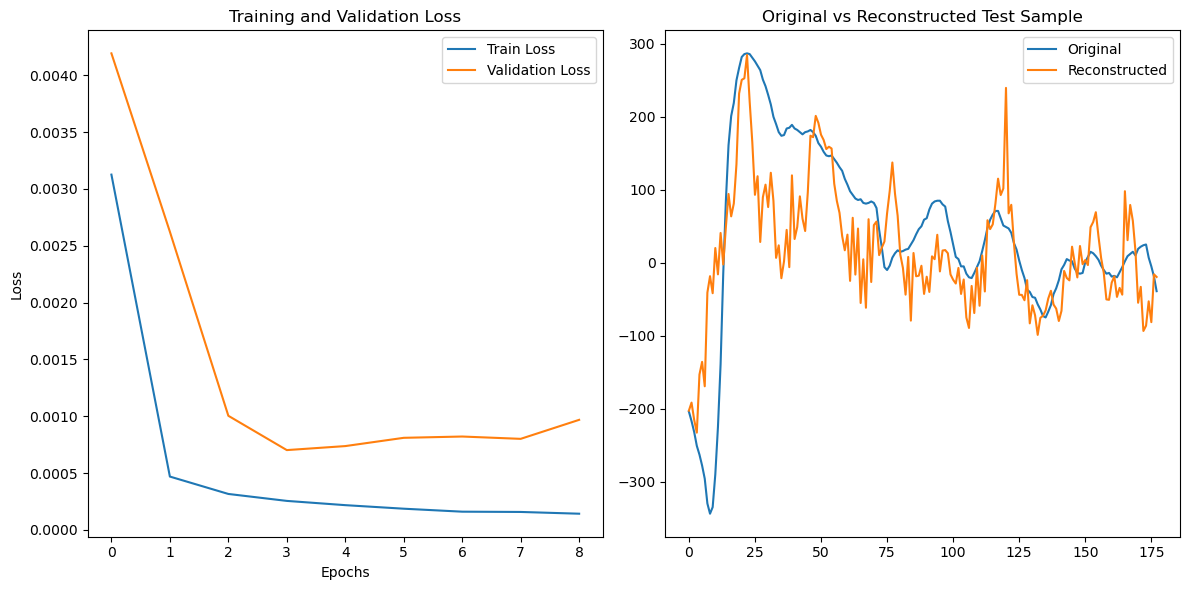

In [8]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0.5, two_d_dropout_rate=0)

## Experiment 2: Dropout after 2d Conv

### Dropout=0.25

Using device: /device:GPU:0
Epoch 1/10


2024-10-27 06:38:49.995695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 [==============================] - 29s 103ms/step - loss: 0.0047 - val_loss: 0.0174
Epoch 2/10
260/260 [==============================] - 26s 102ms/step - loss: 6.5982e-04 - val_loss: 0.0130
Epoch 3/10
260/260 [==============================] - 26s 102ms/step - loss: 4.2042e-04 - val_loss: 6.3931e-04
Epoch 4/10
260/260 [==============================] - 26s 102ms/step - loss: 3.1411e-04 - val_loss: 1.0231e-04
Epoch 5/10
260/260 [==============================] - 27s 102ms/step - loss: 2.5155e-04 - val_loss: 9.7289e-05
Epoch 6/10
260/260 [==============================] - 27s 102ms/step - loss: 2.1015e-04 - val_loss: 8.7124e-05
Epoch 7/10
260/260 [==============================] - 27s 102ms/step - loss: 1.8543e-04 - val_loss: 7.2032e-05
Epoch 8/10
260/260 [==============================] - 27s 102ms/step - loss: 1.6178e-04 - val_loss: 7.2121e-05
Epoch 9/10
260/260 [==============================] - 27s 102ms/step - loss: 1.5094e-04 - val_loss: 8.4792e-05
Epoch 10/10
35/35 [=====

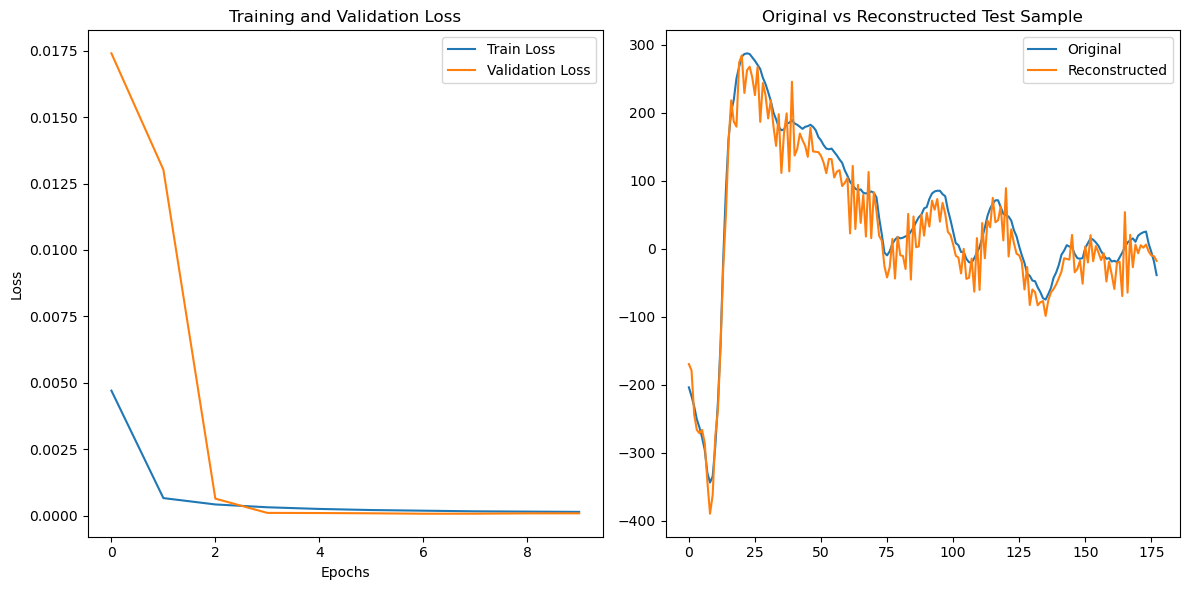

In [14]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.25)

### Dropout=0.5

Using device: /device:GPU:0
Epoch 1/10


2024-10-27 06:43:20.478318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_23/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 [==============================] - 29s 103ms/step - loss: 0.0044 - val_loss: 0.0655
Epoch 2/10
260/260 [==============================] - 26s 102ms/step - loss: 6.3263e-04 - val_loss: 0.0227
Epoch 3/10
260/260 [==============================] - 27s 102ms/step - loss: 3.8051e-04 - val_loss: 9.6734e-04
Epoch 4/10
260/260 [==============================] - 27s 102ms/step - loss: 2.8078e-04 - val_loss: 1.3492e-04
Epoch 5/10
260/260 [==============================] - 27s 102ms/step - loss: 2.3445e-04 - val_loss: 1.1309e-04
Epoch 6/10
260/260 [==============================] - 27s 102ms/step - loss: 2.1417e-04 - val_loss: 2.0502e-04
Epoch 7/10
260/260 [==============================] - 27s 102ms/step - loss: 1.9667e-04 - val_loss: 1.0243e-04
Epoch 8/10
260/260 [==============================] - 27s 102ms/step - loss: 1.7434e-04 - val_loss: 1.0561e-04
Epoch 9/10
260/260 [==============================] - 27s 103ms/step - loss: 1.6224e-04 - val_loss: 9.4870e-05
Epoch 10/10
35/35 [=====

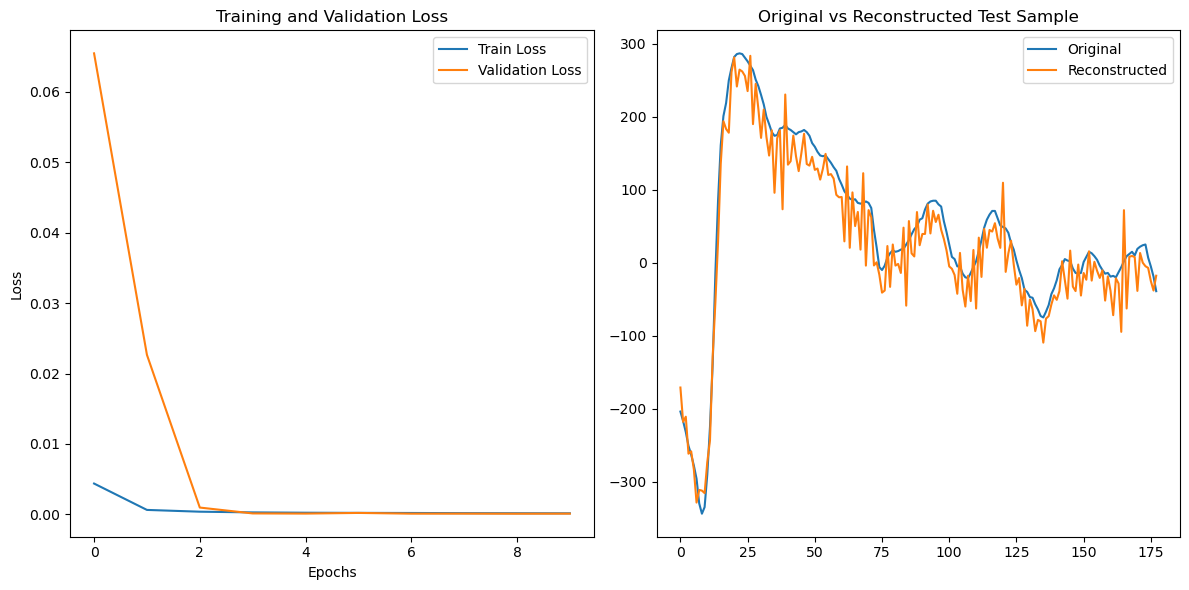

In [15]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.5)

## Best: No dropout

Epoch 1/10
260/260 [==============================] - 25s 80ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 2/10
260/260 [==============================] - 20s 79ms/step - loss: 2.3523e-04 - val_loss: 0.0027
Epoch 3/10
260/260 [==============================] - 21s 79ms/step - loss: 1.5422e-04 - val_loss: 2.4536e-04
Epoch 4/10
260/260 [==============================] - 21s 79ms/step - loss: 1.1041e-04 - val_loss: 1.0956e-04
Epoch 5/10
260/260 [==============================] - 21s 79ms/step - loss: 8.8203e-05 - val_loss: 7.8644e-05
Epoch 6/10
260/260 [==============================] - 21s 79ms/step - loss: 7.3031e-05 - val_loss: 6.4322e-05
Epoch 7/10
260/260 [==============================] - 21s 79ms/step - loss: 6.3162e-05 - val_loss: 5.8751e-05
Epoch 8/10
260/260 [==============================] - 21s 79ms/step - loss: 5.7102e-05 - val_loss: 4.7113e-05
Epoch 9/10
260/260 [==============================] - 21s 79ms/step - loss: 5.3054e-05 - val_loss: 4.4124e-05
Epoch 10/10
35/35 [===

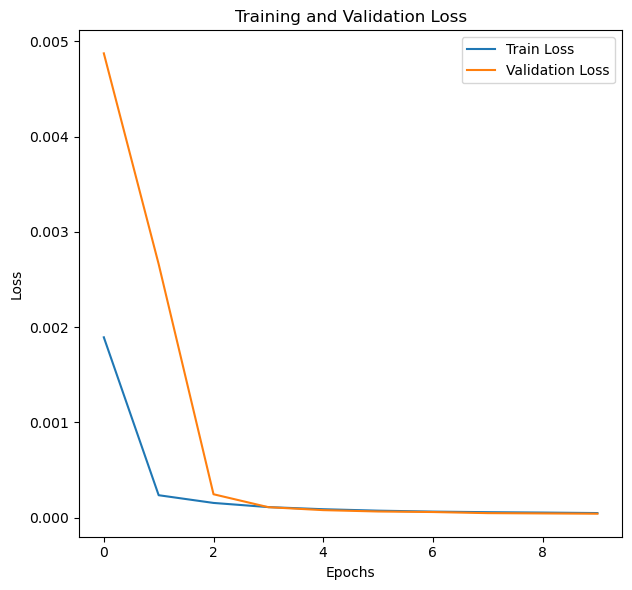

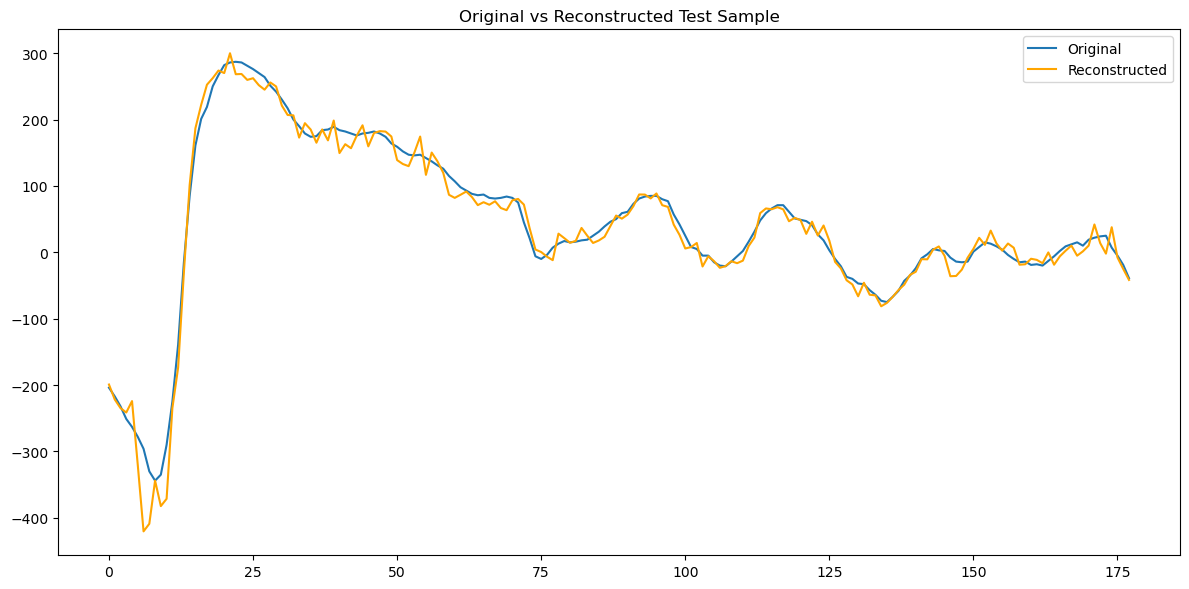

In [10]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_hard_test_split()
autoencoder, encoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

In [8]:
# # Save the model
# from tensorflow.keras.models import load_model

# # Saving the autoencoder and encoder models
# autoencoder.save('autoencoder_model.h5')  # Save the autoencoder
# encoder.save('encoder_model.h5')  # Optionally save the encoder if you want to use it separately

# # Loading the saved models
# autoencoder = load_model('autoencoder_model.h5')
# encoder = load_model('encoder_model.h5')  # Optional if you need the encoder

/opt/conda/envs/capstone/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# II. Test result: before and after autoencoder augmentation

## Using hard test cases data split

In [33]:
def evaluate_classification_metrics(y_true, y_pred, y_pred_prob):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision
    precision = precision_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if len(set(y_true)) > 1:
        # Check if ROC-AUC can be calculated (i.e., both classes are present)
        roc_auc = roc_auc_score(y_true, y_pred_prob)
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(y_true, y_pred)
    else:
        roc_auc = None  # Not computable, only one class in y_true
        kappa = None
    
    # Calculate metrics for seizure class (y_label=1)
    precision_seizure = precision_score(y_true, y_pred, pos_label=1)
    recall_seizure = recall_score(y_true, y_pred, pos_label=1)
    f1_seizure = f1_score(y_true, y_pred, pos_label=1)
    
    # Calculate metrics for non-seizure class (y_label=0)
    precision_non_seizure = precision_score(y_true, y_pred, pos_label=0)
    recall_non_seizure = recall_score(y_true, y_pred, pos_label=0)
    f1_non_seizure = f1_score(y_true, y_pred, pos_label=0)
    
    print(f'\nSeizure (y=1):')
    print(f'  Precision: {precision_seizure * 100:.2f} %')
    print(f'  Recall: {recall_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_seizure * 100:.2f} %')
    
    print(f'\nNon-Seizure (y=0):')
    print(f'  Precision: {precision_non_seizure * 100:.2f} %')
    print(f'  Recall: {recall_non_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_non_seizure * 100:.2f} %')
    
    # Print metrics
    print(f'\nOverall:')
    print(f'  Accuracy: {accuracy * 100:.2f} %')
    print(f'  Precision: {precision * 100:.2f} %')
    print(f'  Recall: {recall * 100:.2f} %')
    print(f'  F1 Score: {f1 * 100:.2f} %')
    if roc_auc is not None:
        print(f'  ROC-AUC: {roc_auc * 100:.2f} %')
    if kappa is not None:
        print(f'  Cohen\'s Kappa: {kappa * 100:.2f} %')

In [35]:
def InceptionNucleus(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_cnn(input_shape=(178, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12])

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x) # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten after 2D Convolutions
    x = Flatten()(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## Before augmentation

##  Inception Nucleus

In [55]:
def train_and_test_classification(X_train, y_train, X_test, y_test, lr_rate=0.0001, num_epochs=30):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create the model
    model = create_eeg_cnn(input_shape=(178, 1), num_classes=2)
    
    # Define the optimizer with a specific learning rate
    optimizer = Adam(learning_rate=lr_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model and store the training history
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  # For evaluation during training
        epochs=num_epochs,                         # Number of epochs
        batch_size=32,                     # Batch size (adjust based on memory)
        shuffle=True,
        callbacks=[early_stopping],        # Early stopping
        verbose=1                          # Print progress
    )
    
    # After training, evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    # Predict class probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities to binary class labels (assuming threshold 0.5)
    y_pred = (y_pred_prob[:, 1] > 0.5).astype(int)
    
    # Evaluate classification metrics using the provided function
    evaluate_classification_metrics(y_test, y_pred, y_pred_prob[:, 1])
    
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    
    # Plot training & validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/30
260/260 [==============================] - 7s 20ms/step - loss: 5.9738 - accuracy: 0.9570 - val_loss: 10.2622 - val_accuracy: 0.9490
Epoch 2/30
260/260 [==============================] - 5s 19ms/step - loss: 4.9906 - accuracy: 0.9708 - val_loss: 2.0689 - val_accuracy: 0.9880
Epoch 3/30
260/260 [==============================] - 5s 19ms/step - loss: 3.4120 - accuracy: 0.9770 - val_loss: 3.6617 - val_accuracy: 0.9731
Epoch 4/30
260/260 [==============================] - 5s 19ms/step - loss: 1.5335 - accuracy: 0.9848 - val_loss: 2.1494 - val_accuracy: 0.9783
Epoch 5/30
260/260 [==============================] - 5s 19ms/step - loss: 2.1447 - accuracy: 0.9828 - val_loss: 1.1486 - val_accuracy: 0.9894
Epoch 6/30
260/260 [==============================] - 5s 19ms/step - loss: 1.0506 - accuracy: 0.9882 - val_loss: 0.9737 - val_accuracy: 0.9909
Epoch 7/30
260/260 [==============================] - 5s 19ms/step - loss: 0.8951 - accuracy: 0.9888 - val_loss: 1.5899 - val_accuracy: 0.989

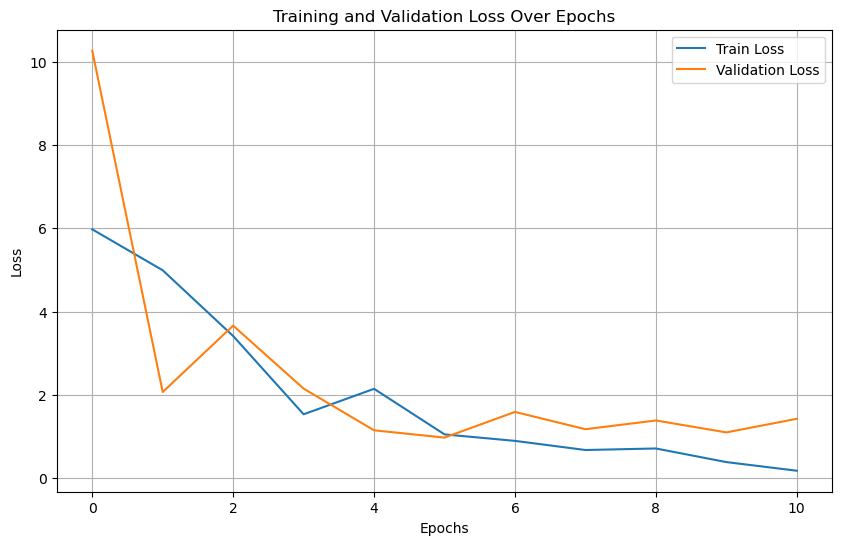

In [32]:
train_and_test_classification(X_train, y_train, X_test, y_test)

Epoch 1/30
260/260 [==============================] - 7s 20ms/step - loss: 0.2831 - accuracy: 0.9049 - val_loss: 0.6389 - val_accuracy: 0.4962
Epoch 2/30
260/260 [==============================] - 5s 19ms/step - loss: 0.1282 - accuracy: 0.9613 - val_loss: 0.1749 - val_accuracy: 0.9413
Epoch 3/30
260/260 [==============================] - 5s 19ms/step - loss: 0.1145 - accuracy: 0.9623 - val_loss: 0.1543 - val_accuracy: 0.9485
Epoch 4/30
260/260 [==============================] - 5s 20ms/step - loss: 0.0860 - accuracy: 0.9692 - val_loss: 0.1094 - val_accuracy: 0.9610
Epoch 5/30
260/260 [==============================] - 5s 19ms/step - loss: 0.0800 - accuracy: 0.9706 - val_loss: 0.0681 - val_accuracy: 0.9774
Epoch 6/30
260/260 [==============================] - 5s 19ms/step - loss: 0.0966 - accuracy: 0.9665 - val_loss: 0.0676 - val_accuracy: 0.9687
Epoch 7/30
260/260 [==============================] - 5s 19ms/step - loss: 0.0722 - accuracy: 0.9723 - val_loss: 0.1312 - val_accuracy: 0.9615

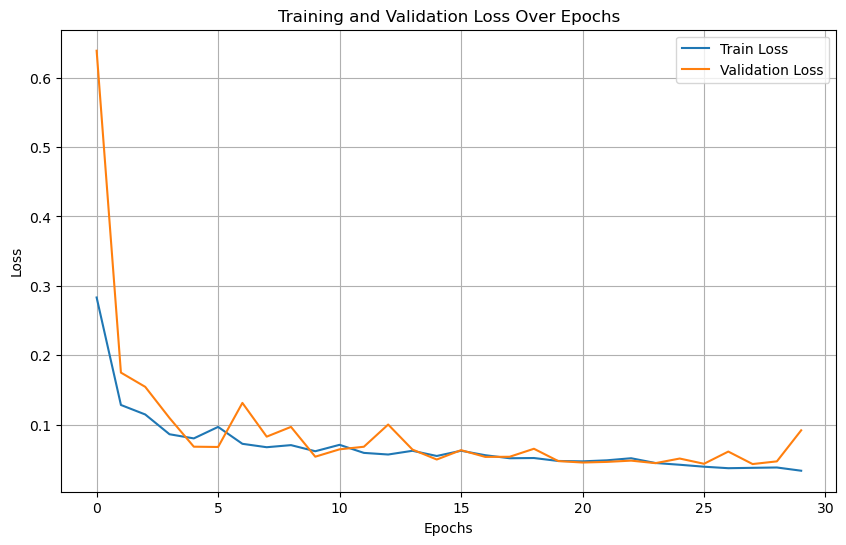

In [42]:
train_and_test_classification(X_train_scaled, y_train, X_test_scaled, y_test)

Conclusion:
1. Scaled dataset behaves worse. This is because the scaler computes its transformation parameters based on the training data distribution. If the test data distribution is very different, these parameters may not be appropriate, leading to skewed or ineffective scaling of the test data, which can negatively affect model performance.
2. Therefore, we only normalize the data if we train and test full data split; if we train and test on the hard test cases data split, we do not normalize.

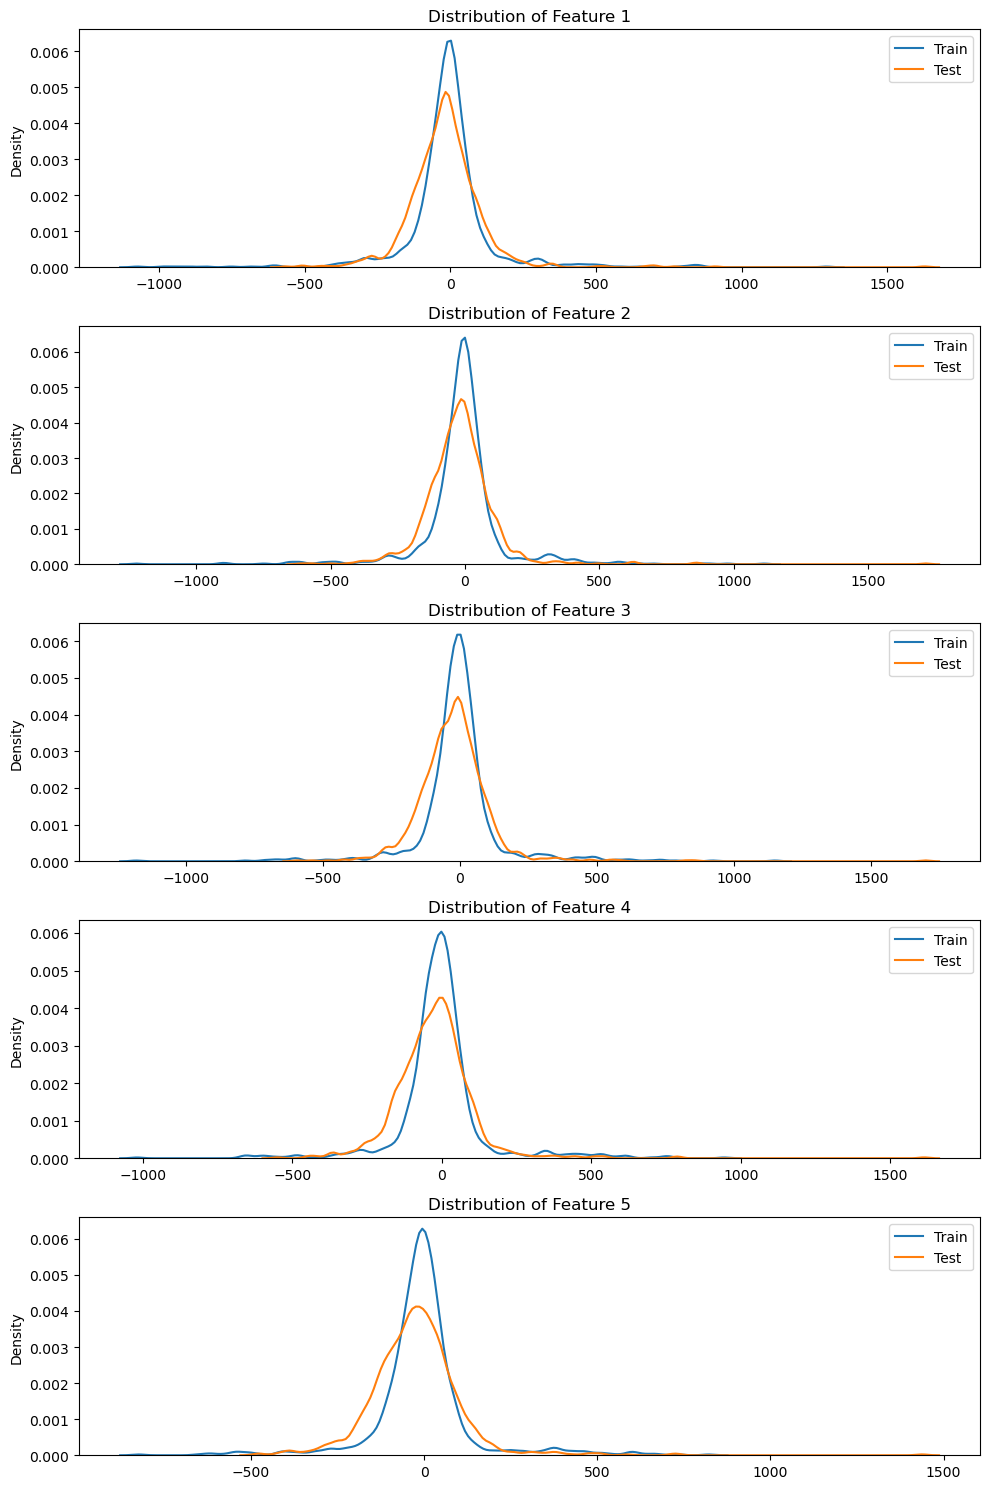

In [46]:
# Train, test data distribution
import numpy as np

def get_subset(X, sample_size=1000):
    if X.shape[0] > sample_size:
        indices = np.random.choice(X.shape[0], sample_size, replace=False)
        return X[indices]
    return X

X_train_sample = get_subset(X_train, sample_size=1000)
X_test_sample = get_subset(X_test, sample_size=1000)


import seaborn as sns

def plot_feature_distributions(X_train, X_test):
    num_features = X_train.shape[1]
    fig, axes = plt.subplots(nrows=min(num_features, 5), ncols=1, figsize=(10, min(num_features, 5) * 3))
    
    for i in range(min(num_features, 5)):  # Limit to first 5 features for efficiency
        feature_name = f"Feature {i+1}"
        sns.kdeplot(X_train[:, i], label='Train', ax=axes[i], bw_adjust=0.5)
        sns.kdeplot(X_test[:, i], label='Test', ax=axes[i], bw_adjust=0.5)
        axes[i].set_title(f'Distribution of {feature_name}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_feature_distributions(X_train_sample, X_test_sample)


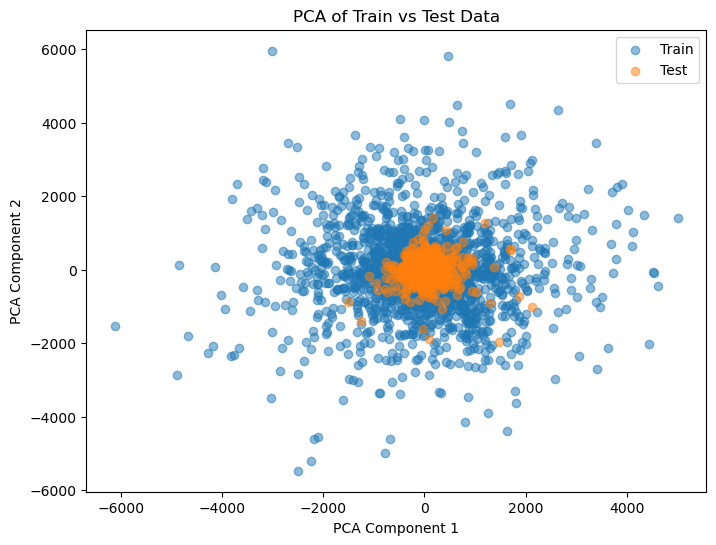

In [48]:
from sklearn.decomposition import IncrementalPCA

def plot_pca(X_train, X_test):
    pca = IncrementalPCA(n_components=2, batch_size=1000)
    X_combined = np.vstack((X_train, X_test))
    X_pca = pca.fit_transform(X_combined)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:len(X_train), 0], X_pca[:len(X_train), 1], label='Train', alpha=0.5)
    plt.scatter(X_pca[len(X_train):, 0], X_pca[len(X_train):, 1], label='Test', alpha=0.5)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of Train vs Test Data')
    plt.legend()
    plt.show()

plot_pca(X_train, X_test)

In [50]:
# A low p-value (e.g., p < 0.05) indicates that the distributions of X_train and X_test are significantly different for that feature.

from scipy.stats import ks_2samp

def ks_test_comparison(X_train, X_test):
    for i in range(X_train.shape[1]):
        statistic, p_value = ks_2samp(X_train[:, i], X_test[:, i])
        print(f"Feature {i+1}: KS Statistic = {statistic}, p-value = {p_value}")

ks_test_comparison(X_train, X_test)

Feature 1: KS Statistic = 0.1116998584420873, p-value = 2.2909186356745266e-11
Feature 2: KS Statistic = 0.12426866362127859, p-value = 5.679016188177743e-14
Feature 3: KS Statistic = 0.14858490566037735, p-value = 8.19385686022433e-20
Feature 4: KS Statistic = 0.15535149854702296, p-value = 1.257855634321892e-21
Feature 5: KS Statistic = 0.14682304983891206, p-value = 2.3564862600846364e-19
Feature 6: KS Statistic = 0.15526008149968282, p-value = 1.3325555750853071e-21
Feature 7: KS Statistic = 0.14298353385062457, p-value = 2.2529438843825515e-18
Feature 8: KS Statistic = 0.13918522478897896, p-value = 1.9802014369672678e-17
Feature 9: KS Statistic = 0.13339478590404533, p-value = 4.853693200890182e-16
Feature 10: KS Statistic = 0.12266540252588073, p-value = 1.2655637421255036e-13
Feature 11: KS Statistic = 0.1061518132432829, p-value = 2.636530150603557e-10
Feature 12: KS Statistic = 0.09194996717296935, p-value = 7.743644196795666e-08
Feature 13: KS Statistic = 0.08679044442536074

## After Augmentation

### Augment dataset
Method 1: Feed reconstructed signal back to Autoencoder n times, to create n different augmented version

Method 2: Add Noise to the Latent Space: Pass the input signal through the encoder to obtain the latent representation, then add noise to the latent representation to generate different versions of the signal.
Add Noise to the Input Signal:

Method 3: Add noise to the input signal before passing it through the autoencoder. This can produce slightly different outputs each time.

#### Method 1: Feed reconstructed signal back to Autoencoder n times, to create n different augmented version.

Augmenting signal for sample 0
Augmenting signal for sample 1


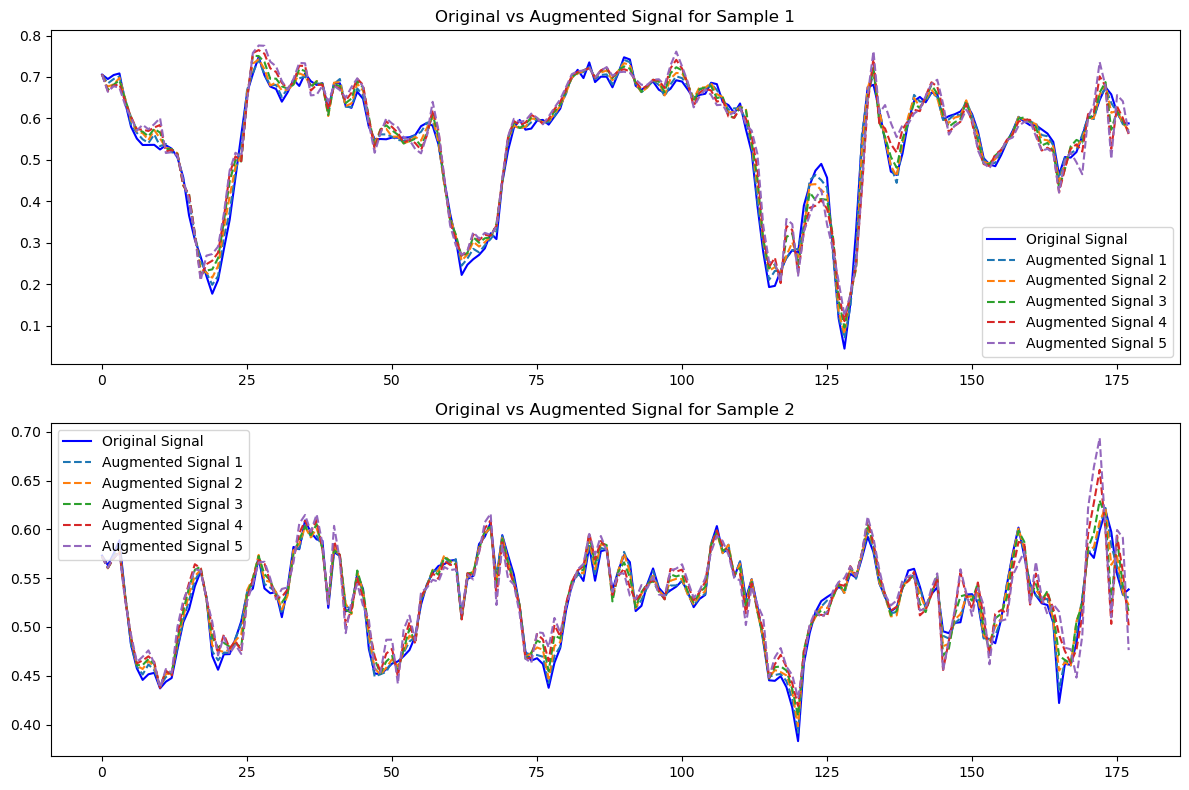

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot original vs augmented signals
def plot_original_vs_augmented(X_original, X_augmented, n_augmentations):
    plt.figure(figsize=(12, 8))
    
    for i in range(2):  # Plot for the first 2 samples
        plt.subplot(2, 1, i + 1)
        plt.plot(X_original[i].squeeze(), label='Original Signal', color='blue')  # Plot original signal
        
        # Plot each of the n_augmentations for the current original signal
        for aug_idx in range(n_augmentations):
            plt.plot(X_augmented[i][aug_idx].squeeze(), label=f'Augmented Signal {aug_idx+1}', linestyle='--')
        
        plt.title(f'Original vs Augmented Signal for Sample {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Function to manually augment a signal n times
def augment_signal_n_times(original_signal_scaled, autoencoder, n=5):
    augmented_signals = []
    current_signal_scaled = original_signal_scaled

    for _ in range(n):
        # Pass the current signal through the autoencoder to get a reconstruction
        reconstructed_scaled = autoencoder.predict(current_signal_scaled, verbose=0)
        
        # Append the augmented signal
        augmented_signals.append(reconstructed_scaled)
        
        # Feed back the perturbed signal for the next iteration
        current_signal_scaled = reconstructed_scaled
    
    # Return the list of augmented signals
    return np.array(augmented_signals)

# Example usage
n_augmentations = 5  # Number of augmentations to generate
first_two_augmented_signals = [[] for _ in range(2)]  # Placeholder for augmented signals for the first two samples

# Augment the first 2 original signals
for sample_idx in range(2):  # For each of the first two samples
    print(f"Augmenting signal for sample {sample_idx}")  # Debugging print
    # Augment each signal 5 times
    augmented_signals = augment_signal_n_times(X_train_scaled[sample_idx:sample_idx+1], autoencoder, n=n_augmentations)
    first_two_augmented_signals[sample_idx] = augmented_signals

# Convert lists into arrays for easier handling
first_two_augmented_signals = [np.array(first_two_augmented_signals[i]) for i in range(2)]

# Plot the original and augmented signals for the first two samples
plot_original_vs_augmented(X_train_scaled[:2], first_two_augmented_signals, n_augmentations)


### Only augment the seizure label

In [48]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tqdm import tqdm

def generate_augmented_data_balanced(X_train, y_train, autoencoder, output_csv='augmented_data.csv'):
    # Reshape X_train if needed to ensure 3D shape (e.g., (samples, 178, 1))
    if X_train.ndim == 2:
        X_train = X_train[..., np.newaxis]

    # Count the samples for each class
    class_counts = np.bincount(y_train)
    n_augmentations = max(class_counts) // min(class_counts) - 1
    print (n_augmentations)

    # Separate samples by class
    X_class_0 = X_train[y_train == 0]
    X_class_1 = X_train[y_train == 1]

    # Initialize lists to store augmented data and labels
    augmented_X = []
    augmented_y = []

    # Add original class 0 data
    for x in X_class_0:
        augmented_X.append(x.flatten())  # Flatten for saving as rows in CSV
        augmented_y.append(0)

    # Add original class 1 data
    for x in X_class_1:
        augmented_X.append(x.flatten())
        augmented_y.append(1)

    # Generate augmented samples for class 1
    for _ in tqdm(range(n_augmentations), desc="Generating augmentations"):
        augmented_class_1 = autoencoder.predict(X_class_1, verbose=0)
        
        # Ensure the augmented data has the correct shape
        for aug in augmented_class_1:
            augmented_X.append(aug.flatten())  # Flatten to save in CSV format
            augmented_y.append(1)

    # Convert lists to arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    # Combine features and labels into a DataFrame
    augmented_df = pd.DataFrame(augmented_X)
    augmented_df['label'] = augmented_y

    # Save to CSV
    augmented_df.to_csv(output_csv, index=False)
    print (augmented_df['label'].value_counts())
    print(f"Augmented data saved to {output_csv}")

In [42]:
generate_augmented_data_balanced(X_train, y_train, autoencoder, output_csv='data/augmented_training_data_balanced.csv')

3


Generating augmentations: 100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


label
0    44160
1    44160
Name: count, dtype: int64
Augmented data saved to data/augmented_training_data_balanced.csv


Epoch 1/30
412/412 [==============================] - 10s 21ms/step - loss: 2.4758 - accuracy: 0.6332 - val_loss: 1.3894 - val_accuracy: 0.7885
Epoch 2/30
412/412 [==============================] - 8s 19ms/step - loss: 0.6293 - accuracy: 0.8933 - val_loss: 0.7973 - val_accuracy: 0.9457
Epoch 3/30
412/412 [==============================] - 8s 19ms/step - loss: 0.1831 - accuracy: 0.9698 - val_loss: 0.1090 - val_accuracy: 0.9827
Epoch 4/30
412/412 [==============================] - 8s 19ms/step - loss: 0.0975 - accuracy: 0.9875 - val_loss: 0.0709 - val_accuracy: 0.9909
Epoch 5/30
412/412 [==============================] - 8s 20ms/step - loss: 0.0977 - accuracy: 0.9893 - val_loss: 0.0841 - val_accuracy: 0.9921
Epoch 6/30
412/412 [==============================] - 8s 20ms/step - loss: 0.1220 - accuracy: 0.9895 - val_loss: 0.1499 - val_accuracy: 0.9891
Epoch 7/30
412/412 [==============================] - 8s 19ms/step - loss: 0.1855 - accuracy: 0.9901 - val_loss: 0.3753 - val_accuracy: 0.980

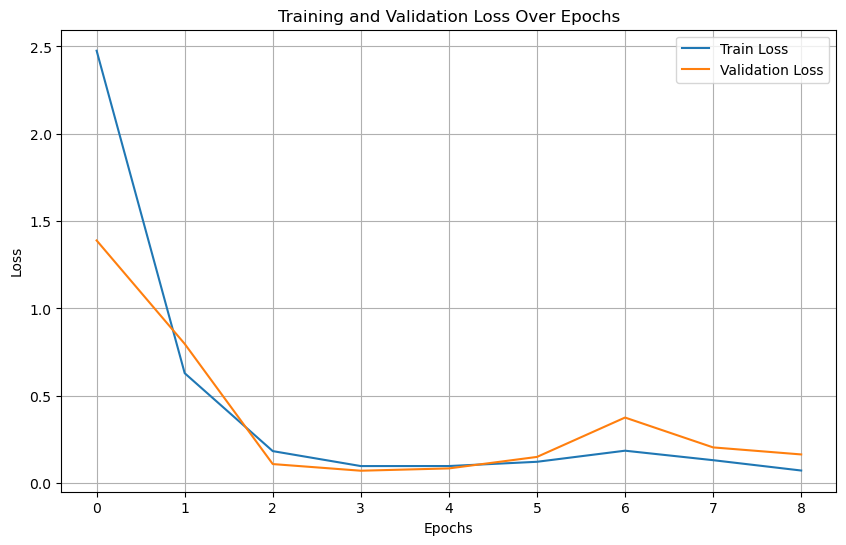

In [ ]:

data = pd.read_csv('data/augmented_training_data_balanced.csv')
X_train = data.iloc[:, :-1].values.reshape(-1, 178, 1)  # Features
y_train = data.iloc[:, -1].values  # Labels

train_and_test_classification(X_train, y_train, X_test, y_test)

### Augment the whole dataset regardless of labels

In [50]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tqdm import tqdm

def generate_augmented_data(X_train, y_train, autoencoder, n_augmentations=5, output_csv='augmented_data.csv'):
    # Reshape X_train if needed to ensure 3D shape (e.g., (samples, 178, 1))
    if X_train.ndim == 2:
        X_train = X_train[..., np.newaxis]

    # Initialize lists to store augmented data and labels
    augmented_X = []
    augmented_y = []

    # Add original data
    for x, y in zip(X_train, y_train):
        augmented_X.append(x.flatten())  # Flatten for saving as rows in CSV
        augmented_y.append(y)

    # Generate n_augmentations for each sample in X_train
    for _ in tqdm(range(n_augmentations), desc="Generating augmentations"):
        augmented_batch = autoencoder.predict(X_train, verbose=0)
        
        # Ensure the augmented data has the correct shape
        for aug, y in zip(augmented_batch, y_train):
            augmented_X.append(aug.flatten())  # Flatten to save in CSV format
            augmented_y.append(y)

    # Convert lists to arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    # Combine features and labels into a DataFrame
    augmented_df = pd.DataFrame(augmented_X)
    augmented_df['label'] = augmented_y

    # Save to CSV
    augmented_df.to_csv(output_csv, index=False)
    print(augmented_df['label'].value_counts())
    print(f"Augmented data saved to {output_csv}")

In [51]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_hard_test_split()
generate_augmented_data(X_train, y_train, autoencoder, output_csv='data/augmented_training_data_unbalanced.csv')

Generating augmentations: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


label
0    50160
1    12168
Name: count, dtype: int64
Augmented data saved to data/augmented_training_data_unbalanced.csv


In [ ]:
data = pd.read_csv('augmented_training_data.csv')
X_train = data.iloc[:, :-1].values.reshape(-1, 178, 1)  # Features
y_train = data.iloc[:, -1].values  # Labels

train_and_test_classification(X_train, y_train, X_test, y_test)

# Use normal train/test split: 80% training 20% test random split

## Train Autoencoder

Epoch 1/10
230/230 [==============================] - 22s 79ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 2/10
230/230 [==============================] - 18s 78ms/step - loss: 3.0657e-04 - val_loss: 0.0033
Epoch 3/10
230/230 [==============================] - 18s 78ms/step - loss: 1.8292e-04 - val_loss: 6.8346e-04
Epoch 4/10
230/230 [==============================] - 18s 78ms/step - loss: 1.3782e-04 - val_loss: 1.2875e-04
Epoch 5/10
230/230 [==============================] - 18s 78ms/step - loss: 1.1268e-04 - val_loss: 9.0339e-05
Epoch 6/10
230/230 [==============================] - 18s 78ms/step - loss: 8.9081e-05 - val_loss: 7.9924e-05
Epoch 7/10
230/230 [==============================] - 18s 78ms/step - loss: 7.7289e-05 - val_loss: 6.9663e-05
Epoch 8/10
230/230 [==============================] - 18s 78ms/step - loss: 6.8790e-05 - val_loss: 5.8457e-05
Epoch 9/10
230/230 [==============================] - 18s 78ms/step - loss: 5.8058e-05 - val_loss: 5.8938e-05
Epoch 10/10
72/72 [===

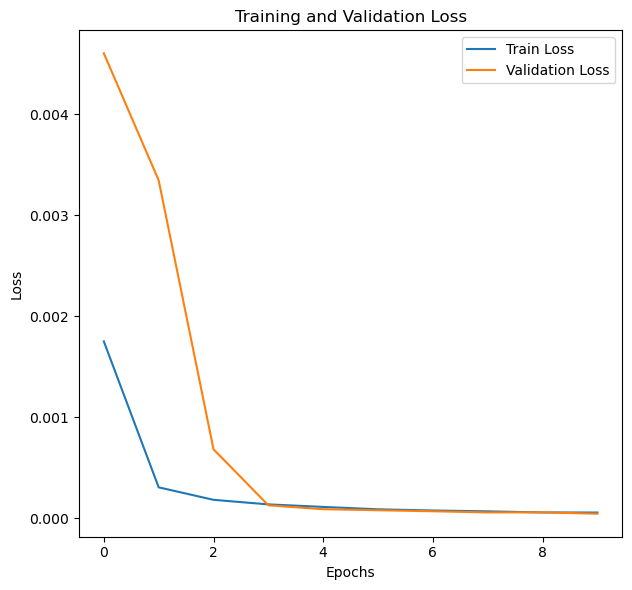

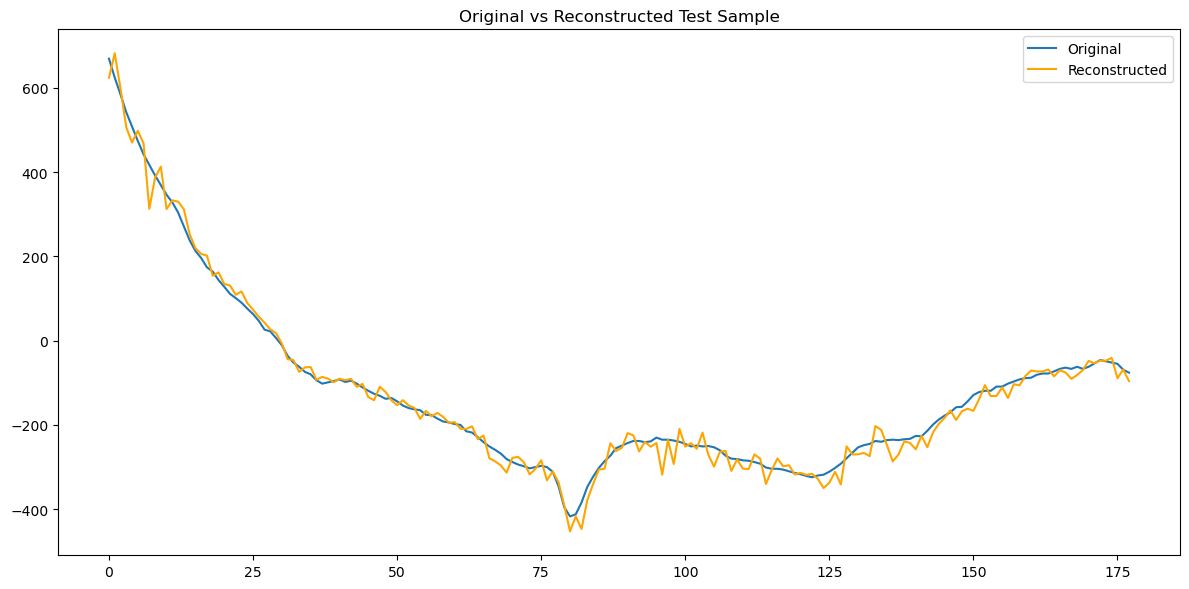

In [31]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_test_split()
autoencoder, encoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

## Train detection model

### Before augmentation

Epoch 1/30
230/230 [==============================] - 6s 20ms/step - loss: 1.2145 - accuracy: 0.9261 - val_loss: 0.8308 - val_accuracy: 0.9375
Epoch 2/30
230/230 [==============================] - 4s 19ms/step - loss: 1.1775 - accuracy: 0.9405 - val_loss: 0.5700 - val_accuracy: 0.9582
Epoch 3/30
230/230 [==============================] - 4s 19ms/step - loss: 0.7408 - accuracy: 0.9511 - val_loss: 0.4502 - val_accuracy: 0.9668
Epoch 4/30
230/230 [==============================] - 4s 19ms/step - loss: 0.6583 - accuracy: 0.9535 - val_loss: 0.4867 - val_accuracy: 0.9674
Epoch 5/30
230/230 [==============================] - 4s 19ms/step - loss: 0.4434 - accuracy: 0.9641 - val_loss: 0.5395 - val_accuracy: 0.9592
Epoch 6/30
230/230 [==============================] - 4s 19ms/step - loss: 0.4907 - accuracy: 0.9652 - val_loss: 0.4469 - val_accuracy: 0.9712
Epoch 7/30
230/230 [==============================] - 4s 19ms/step - loss: 0.4629 - accuracy: 0.9664 - val_loss: 0.3549 - val_accuracy: 0.9685

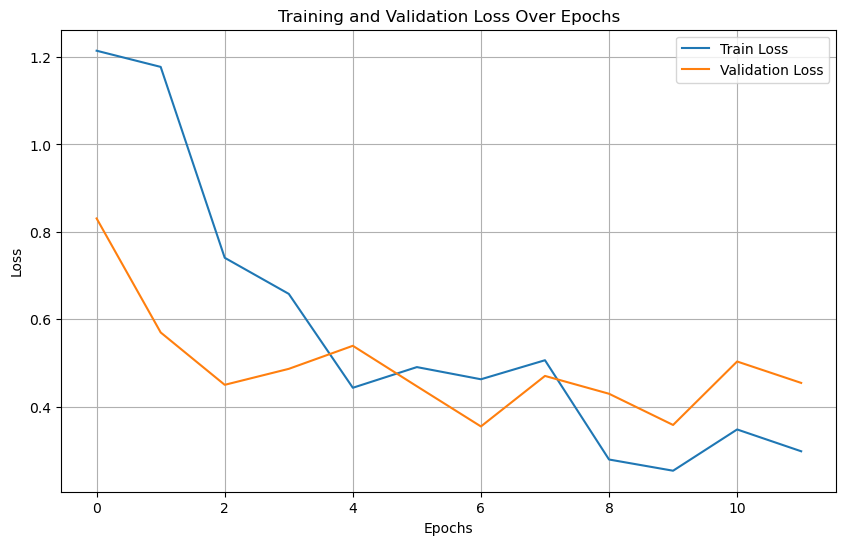

In [36]:
train_and_test_classification(X_train, y_train, X_test, y_test)

### After augmentation

#### Only augment seizure labels

In [44]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_test_split()
generate_augmented_data_balanced(X_train, y_train, autoencoder, output_csv='data/augmented_training_balanced_8020_split.csv')

3


Generating augmentations: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


label
0    7360
1    7360
Name: count, dtype: int64
Augmented data saved to data/augmented_training_balanced_8020_split.csv


Epoch 1/30
368/368 [==============================] - 8s 19ms/step - loss: 2.5566 - accuracy: 0.6415 - val_loss: 3.9269 - val_accuracy: 0.7901
Epoch 2/30
368/368 [==============================] - 7s 19ms/step - loss: 0.7595 - accuracy: 0.9001 - val_loss: 1.7445 - val_accuracy: 0.5577
Epoch 3/30
368/368 [==============================] - 7s 19ms/step - loss: 0.4406 - accuracy: 0.9613 - val_loss: 0.3116 - val_accuracy: 0.9711
Epoch 4/30
368/368 [==============================] - 7s 19ms/step - loss: 0.3504 - accuracy: 0.9727 - val_loss: 0.3276 - val_accuracy: 0.9728
Epoch 5/30
368/368 [==============================] - 7s 19ms/step - loss: 0.4209 - accuracy: 0.9711 - val_loss: 0.4303 - val_accuracy: 0.9698
Epoch 6/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2635 - accuracy: 0.9808 - val_loss: 0.4077 - val_accuracy: 0.9728
Epoch 7/30
368/368 [==============================] - 7s 19ms/step - loss: 0.2490 - accuracy: 0.9799 - val_loss: 0.3974 - val_accuracy: 0.9725

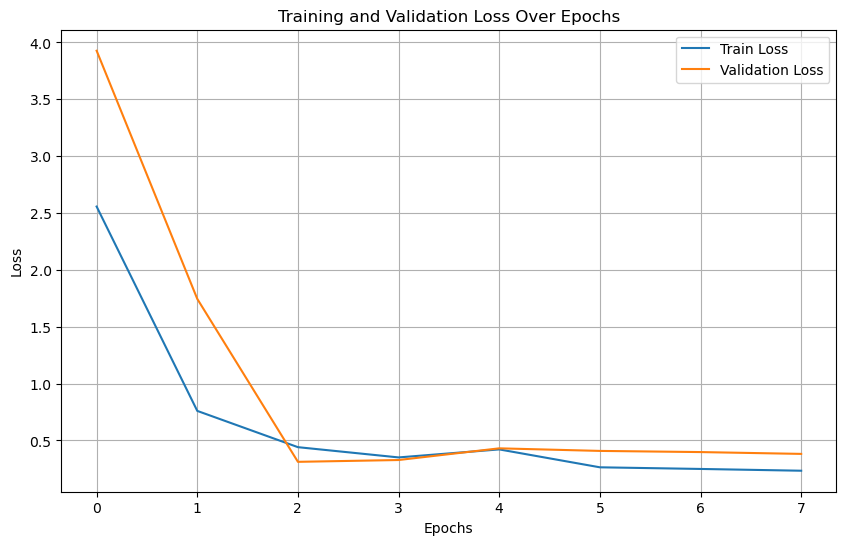

In [46]:
data = pd.read_csv('data/augmented_training_balanced_8020_split.csv')
X_train = data.iloc[:, :-1].values.reshape(-1, 178, 1)  # Features
y_train = data.iloc[:, -1].values  # Labels

train_and_test_classification(X_train, y_train, X_test, y_test)

#### Augment all data without labels

In [53]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_test_split()
generate_augmented_data(X_train, y_train, autoencoder, output_csv='data/augmented_training_data_unbalanced_8020_split.csv')

Generating augmentations: 100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


label
0    44160
1    11040
Name: count, dtype: int64
Augmented data saved to data/augmented_training_data_unbalanced_8020_split.csv


Epoch 1/100
1380/1380 [==============================] - 27s 19ms/step - loss: 2.2336 - accuracy: 0.7351 - val_loss: 1.0029 - val_accuracy: 0.8048
Epoch 2/100
1380/1380 [==============================] - 26s 19ms/step - loss: 1.2216 - accuracy: 0.7657 - val_loss: 0.7743 - val_accuracy: 0.7394
Epoch 3/100
1380/1380 [==============================] - 26s 19ms/step - loss: 0.9637 - accuracy: 0.7858 - val_loss: 0.6835 - val_accuracy: 0.8249
Epoch 4/100
1380/1380 [==============================] - 26s 19ms/step - loss: 0.7665 - accuracy: 0.8044 - val_loss: 0.6544 - val_accuracy: 0.8434
Epoch 5/100
1380/1380 [==============================] - 26s 19ms/step - loss: 0.8402 - accuracy: 0.8051 - val_loss: 0.6958 - val_accuracy: 0.8379
Epoch 6/100
1380/1380 [==============================] - 26s 19ms/step - loss: 0.6513 - accuracy: 0.8190 - val_loss: 0.6273 - val_accuracy: 0.8560
Epoch 7/100
1380/1380 [==============================] - 26s 19ms/step - loss: 0.6075 - accuracy: 0.8305 - val_loss: 0

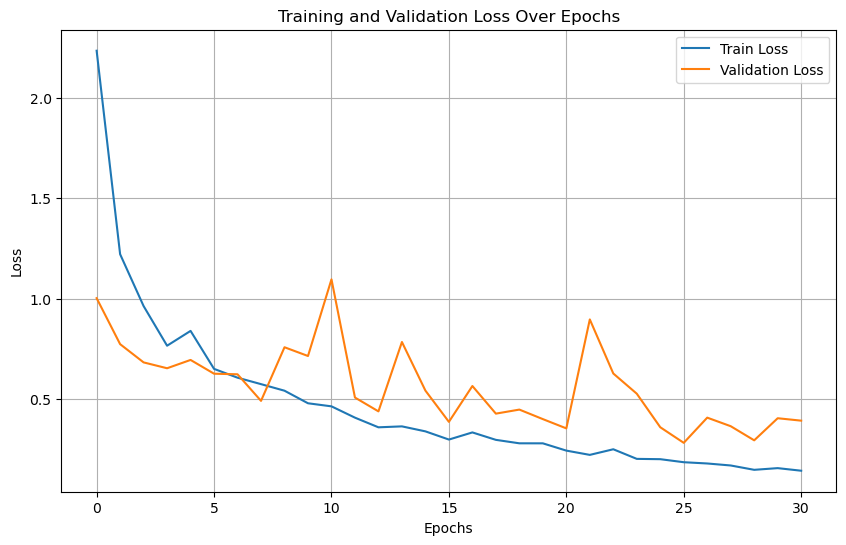

In [58]:
data = pd.read_csv('data/augmented_training_data_unbalanced_8020_split.csv')
X_train = data.iloc[:, :-1].values.reshape(-1, 178, 1)  # Features
y_train = data.iloc[:, -1].values  # Labels

train_and_test_classification(X_train, y_train, X_test, y_test, num_epochs=100)